In [1]:
from tensorflow.keras.layers import Input, AveragePooling2D, ReLU, AlphaDropout, Conv2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG16, MobileNetV2, ResNet50V2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Pre-processing of the images

In [3]:
#LOAD THE DATA

#Data split
train_path="swatdcnn/data/Augmented/stage_3/train"
val_path="swatdcnn/data/Augmented/stage_3/validation"
test_path="swatdcnn/test/stage-3/test"

#Set image shapes
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)

In [4]:
IMG_SIZE = (224,224)

def ImgDataGen(file_path,f=False):    
    file_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    file_set = file_datagen.flow_from_directory(
        file_path,
        target_size = IMG_SIZE,
        batch_size = 16,
        class_mode = 'categorical',
        shuffle = f,
        seed =  42,
    )
    return file_set

In [5]:
training_set, test_set, val_set = ImgDataGen(train_path, f=True), ImgDataGen(test_path), ImgDataGen(val_path)

Found 6000 images belonging to 4 classes.
Found 87 images belonging to 4 classes.
Found 177 images belonging to 4 classes.


In [7]:
nb_train_samples = len(training_set.filenames)
nb_validation_samples = len(val_set.filenames)
nb_test_samples = len(test_set.filenames)
num_classes= len(training_set.class_indices)
labels = [i for i in training_set.class_indices]
print(labels)

['0_Cercospora', '1_Phoma', '2_Leaf_Miner', '3_Red_Spider_Mite']


# Training using InceptionV3

In [8]:
def my_model(model_input):
    InceptionV3_builder = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_tensor = model_input
    )

#FINE-TUNING
    for layer in InceptionV3_builder.layers:
        layer.trainable = False
    for BatchNormalization in InceptionV3_builder.layers:
        BatchNormalization.trainable = True
    x = InceptionV3_builder.layers[-1].output    
    x = GlobalAveragePooling2D(name='GAP-inceptionv3')(x)
    x = Dropout(0.5, name='Droput-inceptionv3')(x)
    predictions = Dense(num_classes, activation='softmax', name='Softmax-inceptionv3')(x)
    model = Model(inputs=InceptionV3_builder.input, outputs=predictions, name='inceptionv3')
    return model

In [9]:
model = my_model(model_input)
# model.summary()

In [10]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=2,
    verbose=1, 
    mode='max',
    min_lr=0.000001
)

callbacks = [reduce_lr]

history = model.fit(
    training_set, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs, 
    validation_data=val_set,
    callbacks=callbacks, 
    validation_steps=nb_validation_samples // batch_size, 
    verbose=1
)

elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print(train_time, 'train_time')
print(elapsed_time, 'Seconds')

Epoch 1/25
375/375 [==============================] - 759s 2s/step - loss: 0.3596 - accuracy: 0.8675 - val_loss: 0.4916 - val_accuracy: 0.8466 - lr: 0.0010
Epoch 2/25
375/375 [==============================] - 663s 2s/step - loss: 0.1946 - accuracy: 0.9355 - val_loss: 0.5894 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 3/25
375/375 [==============================] - 664s 2s/step - loss: 0.1516 - accuracy: 0.9518 - val_loss: 2.4629 - val_accuracy: 0.5852 - lr: 0.0010
Epoch 4/25
375/375 [==============================] - 662s 2s/step - loss: 0.1428 - accuracy: 0.9520 - val_loss: 0.2870 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 5/25
375/375 [==============================] - 615s 2s/step - loss: 0.0881 - accuracy: 0.9712 - val_loss: 0.3488 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 6/25
375/375 [==============================] - 595s 2s/step - loss: 0.0842 - accuracy: 0.9740 - val_loss: 0.3097 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 7/25
375/375 [==============================] - ETA: 0s - 

# Reporting 

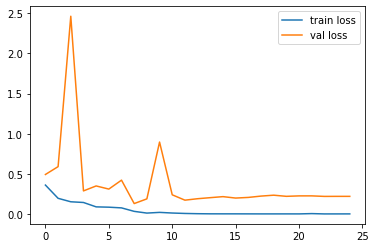

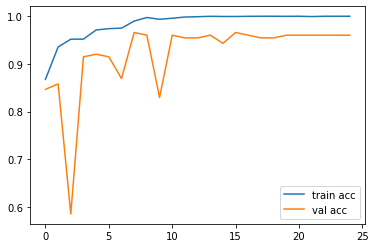

In [11]:
def report_train(history):
    # loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    # accuracies
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

report_train(history)

Report Test

6/6 [==============================] - 4s 558ms/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.97      1.00      0.99        33
           2       0.97      0.97      0.97        32
           3       1.00      1.00      1.00        13

    accuracy                           0.98        87
   macro avg       0.98      0.96      0.97        87
weighted avg       0.98      0.98      0.98        87



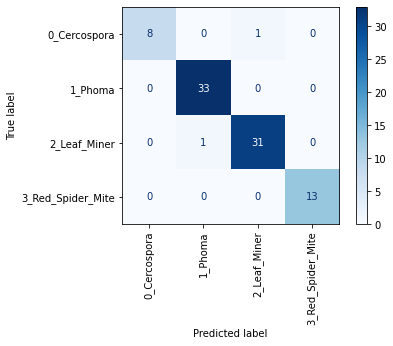

In [12]:
def report_test(test_set,model=model):
    
    # evaluating test
    model.evaluate(test_set,batch_size=32)
    y_pred=model.predict(test_set)
    y_pred=np.argmax(y_pred,axis=1)
    accuracy_score(y_pred,test_set.classes)
    print(classification_report(y_pred,test_set.classes))
    
    # confusion_matrix
    labels = [i for i in training_set.class_indices]
    cm =confusion_matrix(y_pred, test_set.classes)
    disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    disp.plot(cmap='Blues',xticks_rotation='vertical')
    plt.show()

report_test(test_set)

# Export the Model

Save model

In [13]:
file_model = "InceptionV3_3.h5"
tf.keras.models.save_model(model,file_model)
# tf.keras.models.save_weights(model,file_weights)

Save history

In [14]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
path = 'history/'
# save to json:  
hist_json_file = 'InceptionV3_3.json' 
with open(path+hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'InceptionV3_3.csv'
with open(path+hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)